# Network construction & Community detection--Twitter data

### We are given the data from tweeter, recording users' ID and the time and location when they post anything. Our basic idea is to construct a network where we observe the relation among places by analyzing people's activities near each location, trying to detect grouping communities and distinguish weak links from strong ones.

### Step 1,  load the data from twitter and categorize it by weekdays/weekend

In [51]:
%pwd

u'/Users/CQ/Documents/Project1/CommunityDetection'

In [52]:
from __future__ import print_function
import matplotlib.pyplot as plt
import networkx as nx #library supporting networks
#make sure plots are embedded into the notebook
%pylab inline
import scipy
import numpy as np
import pandas as pd
from datetime import datetime
import csv
import matplotlib
from mpl_toolkits import basemap
from descartes import PolygonPatch
from shapely.geometry.polygon import Polygon
from matplotlib import colors
from mpl_toolkits.basemap import shapefile as shp
import community #Louvain method
import operator
from datetime import timedelta, date
import time
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


#### Some information about these files:
* zipsf is the shapefile of zip codes from all over the United States, provided by CUSP at NYU
* twitter_file is the main database here, recording all tweeting activities from *Nov.4th 2015 to Feb.12th 2016*
* USzipcode is the dataframe containing zipcodes in U.S. but there are some zipcodes missing, and we will only provide analysis based on the zipcodes we have here in the database
* NOTE: For the majority of missing zipcodes, personal experience tells me that those zipcodes are usually parks or forests, in other words, the places where postal service is not needed much

In [53]:
zipsf = shp.Reader('/Users/CQ/Documents/Project1/ManhattanStreetMap/cb_2014_us_zcta510_500k.shp')
zipsf_records = zipsf.records()
zipsf_shape = zipsf.shapeRecords()
twitter_file = pd.read_csv('/Users/CQ/Documents/Project1/2016_02_18_sintetic.csv')
USzipcode = pd.read_csv('/Users/CQ/Documents/Project1/USzipcode_XY.csv')

#### Convert time stamp into time format and then categorize our data into four different datasets:
1. All data, labeled  All days with **date_index 0**
2. Data from weekdays, labeled  Weekdays with **date_index 1**
3. Data from Saturdays, labeled  Saturdays with **date_index 2**
4. Data from Sundays, labeled  Sundays with **date_index 3**

In [54]:
TimeList = range(4)
TimeList[0] = [time.localtime(x) for x in twitter_file.timestamp]
TimeList[1] = [x for x in TimeList[0] if x.tm_wday < 5]
TimeList[2] = [x for x in TimeList[0] if x.tm_wday == 5]
TimeList[3] = [x for x in TimeList[0] if x.tm_wday == 6]
twitter_file.iloc[:,0] = TimeList[0]

twitter_file.columns = ['DateTime','Stamp','ZipCode','User','ID']
USzipcode.columns = ['ZipCode','lat','lon']

#### Change the columns' names as above, compute and filter the results, drop all zeros

In [55]:
def Clean_zipcode(dataset):
    zipcode_all = list(sorted(set(dataset.ZipCode)))
    zip_exist = [i for i in zipcode_all if i in USzipcode.ZipCode.values]
    return dataset[dataset.ZipCode.isin(zip_exist)]

In [56]:
Data = range(4)
for i in range(4):
    Data[i] = twitter_file[twitter_file.DateTime.isin(TimeList[i])]
    Data[i] = Clean_zipcode(Data[i])

### Step 2, construct a network with the probability, or equivalently, the weight of link(a,b) defined as
### $$link(a,b) = \Sigma_c\frac{t(c,a)*(t(c,b)-\delta(a,b))}{T*(t(c)-1)}$$
### where
* *t(c,a)* denotes the total number of tweets that user *c* has posted at location (in our case, zipcode) *a*
* $t(c) = \Sigma_a t(c,a)$
* $T = \Sigma_c t(c)$

In [57]:
def Network_prob_build(dataset):
    graph = nx.DiGraph()
    places = [int(x[-5:]) for x in list(dataset.columns)[1:]]
    graph.add_nodes_from(places)
    T = sum(sum(dataset)[1:])
    tc = sum(dataset.iloc[:,1:], axis = 1)
    #TC = dict(zip(list(dataset.UserID), tc))
    ix_tc = tc > 1
    #the formula is provided above
    for a in places:
        ix_a = places.index(a)
        for b in places:
            ix_b = places.index(b)
            if ix_a != ix_b:
                w = dataset.iloc[:,ix_a+1][ix_tc] * dataset.iloc[:,ix_b+1][ix_tc] / (tc[ix_tc]-1)
                graph.add_edge(a,b, weight = sum(w)/T )
            else:
                w = dataset.iloc[:,ix_a+1][ix_tc] * (dataset.iloc[:,ix_b+1][ix_tc]-1) / (tc[ix_tc]-1)
                graph.add_edge(a,b, weight = sum(w)/T )
    return graph

#### Compared with our original network, here we label it as Network2

#add unit weights to unweighted network nodes
def make_directed_and_weighted(G):
    DG = nx.DiGraph()
    DG.add_nodes_from(G.nodes())
    
    for e in G.edges():
        v1 = min(e[0],e[1])
        v2 = max(e[0],e[1])
        w = G[v1][v2]['weight']
        #if it's a loop edge, we double its weight
        if v1==v2:
            DG.add_edge(v1,v2, weight = 2 * w)
        #otherwise we set the weight of A->B equal to the weight of B->A
        else:
            DG.add_edge(v1,v2, weight = w)
            DG.add_edge(v2,v1, weight = w)
    return DG

In [58]:
Net2, Net = range(4), range(4)
LABEL = ['All ','Week','Satur','Sun']

# WARNING: NEXT CELL MAY TAKE MORE THAN 22 HOURS TO RUN, WE'VE EXTRACTED THOSE DATA TO EXTERNAL FILES FOR FUTURE USAGE.

for i in range(4):
    Net2[i] = Normalized_weight(Data[i])
    Net2[i].to_csv('/Users/CQ/Documents/Project1/Network2 for '+LABEL[i]+'days.csv')

#### Now we load the data for further analysis

In [59]:
for i in range(4):
    Net[i] = pd.read_csv('/Users/CQ/Documents/Project1/Network1/Network of '+LABEL[i]+'days.csv').iloc[:,1:]
    Net2[i] = pd.read_csv('/Users/CQ/Documents/Project1/Network2/Network2 for '+LABEL[i]+'days.csv')
    Net2[i].rename(columns={'Unnamed: 0':'UserID'}, inplace=True)

### Step 3, proceed to community detection, first construct the directed graphs based on the probabilistic methods, then plot the graphs

#### Convert these dataframes into directed graphs, and then perform combo partition and community plotting to see the results

In [60]:
def Network_naive_build(date_index = 0):
    Graph = nx.Graph()
    Graph.add_nodes_from(Data[date_index].ZipCode.unique())
    for i in range(len(Net[date_index])):
        w = Net[date_index].iloc[i,:]
        if w[0] != w[1]:
            Graph.add_edge(w[0],w[1],weight = w[2])
            Graph.add_edge(w[1],w[0],weight = w[2])
        else:
            Graph.add_edge(w[0],w[1],weight = 2* w[2])
    return Graph

In [61]:
Graph, Graph2 = range(4), range(4)
for i in range(4):
    Graph[i] = Network_naive_build(i)
    Graph2[i] = Network_prob_build(Net2[i])

Start with Louvain method if curious but not necessary, next try combo algorithm with Inf, 2, and 4 communities parititions.
* We will run tests for graphs both with and without loop edges
* Please note that you may have to downgrade the version of package networkx from 1.11 to 1.9.1 in order to successfully plot the graph  (--week 3, March 3rd 2016)

In [62]:
import os
workfolder = '/Users/CQ/Documents/Project1/CommunityDetection'
os.chdir(workfolder)

In [63]:
#interface for running compiled combo over the network G given a maximal number of communities maxcom
def getComboPartition(G, maxcom):
    #save network in net format
    nodes={}
    nodenum={}
    i=0
    #create a dictionary transforming nodes to unique numbers
    for n in G.nodes():
        nodenum[n]=i
        nodes[i]=n
        i+=1
    f = open('combo/temp.net', 'w')
    f.write('*Arcs\n')
    for e in G.edges(data=True):
        f.write('{0} {1} {2}\n'.format(nodenum[e[0]],nodenum[e[1]],e[2]['weight']))
    f.close()
    #run combo
    command=workfolder+'/combo/comboCPP combo/temp.net'
    if maxcom<Inf:
        command=command+' {0}'.format(maxcom)  
    os.system(command)
    #read resulting partition
    f = open('combo/temp_comm_comboC++.txt', 'r')
    i=0
    partition={}
    for line in f:
        partition[nodes[i]]=int(line)
        i+=1
    return partition

In [64]:
N_CP4, P_CP4 = range(4), range(4)
for i in range(4):
    N_CP4[i] = getComboPartition(Graph[i], 4)
    P_CP4[i] = getComboPartition(Graph2[i], 4)

In [65]:
def modularity(G, partition):
    #compute network modularity according to the given partitioning
    nodes=G.nodes()
    #compute node weights and total network weight
    if G.is_directed():
        w1=G.out_degree(weight='weight')
        w2=G.in_degree(weight='weight')
        T=1.0*sum([e[2]['weight'] for e in G.edges(data=True)])
    else:
        w1=G.degree(weight='weight')
        w2=G.degree(weight='weight')
        T=1.0*sum([(1+(e[0]!=e[1]))*e[2]['weight'] for e in G.edges(data=True)])
    M=0.0 #start accumulating modularity score
    for a in nodes:
        for b in nodes:
            #if (G.is_directed())|(b>=a):
            if partition[a]==partition[b]: #if nodes belong to the same community
                    #get edge weight
                if G.has_edge(a,b):
                    e=G[a][b]['weight']
                else:
                    e=0
                M+=e/T-w1[a]*w2[b]/(T**2) #add modularity score for the considered edge 
    return M

In [66]:
def CommPartShape(fig, G, partition, date_index):
    '''This functin is for plotting geographical maps with 4 arguments:
    fig: for subplotting purpose mainly, usually not necessary
    G: the graph, does not have to be directed, for modularity computation
    partitin: self-explanatory, although it can be non-integers
    data_index: 0 denoting all data, and 1, 2, 3 for weekday, Saturday, Sunday
    '''
    if max([a-int(a) for a in partition.values()])==0:
        cmap = matplotlib.cm.hsv(np.linspace(0,1,max(partition.values())+2))
        mode = 1
    else:
        cmap = matplotlib.cm.cool(np.linspace(0,1,128))
        mode = 2
        v2 = log(max(partition.values()))
        v1 = log(min(partition.values()))
    title = ['All Data','Weekdays', 'Saturdays', 'Sundays']
    
    ClusterList = [ (j, partition.values().count(j)*1.0/len(partition)) for j in set(partition.values())]
    ClusterList.sort(key = operator.itemgetter(1), reverse = 1)
    ClusterRanking = [i[0] for i in ClusterList]
    
    ax = fig.add_subplot(221 + date_index)
    plt.title(title[date_index]+', modularity %f' % modularity(G,partition), fontweight="bold", size=15)
    for s in range(lzipsf):
        z = int(zipsf_records[s][1][-5:])
        if z in partition.keys():
            k = partition[z]
            if mode == 2:
                k = int((log(k)-v1)/(v2-v1)*127.9999)
            c = cmap[ClusterRanking.index(k)][0:3]
            shape = zipsf_shape[s]
            w = [(i[0],i[1]) for i in shape.shape.points]
            poly = Polygon(w)
            ax.add_patch(PolygonPatch(poly, fc = c, ec = c, alpha = 0.6, zorder = 2))
    ax.axis('scaled')
    ax.legend()
    plt.subplots_adjust(hspace = 0.1, wspace = 0)
    return ClusterRanking

In [67]:
lzipsf = len(zipsf_shape)
ClusterRanking = range(4)

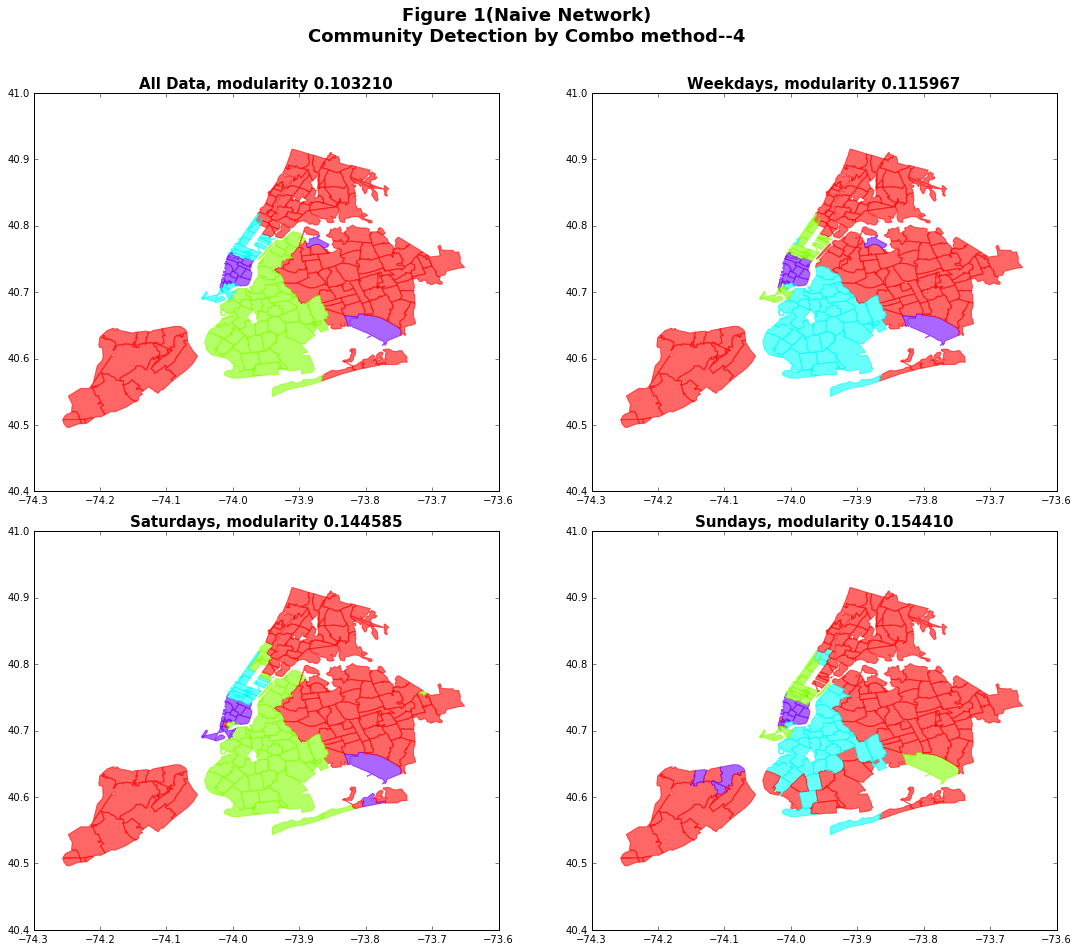

In [68]:
fig1 = plt.figure(num = 1, figsize = (20,15))
plt.suptitle('Figure 1(Naive Network)\nCommunity Detection by Combo method--4', fontweight="bold", size=18)
for i in range(4):
    CommPartShape(fig1, Graph[i], N_CP4[i], i)

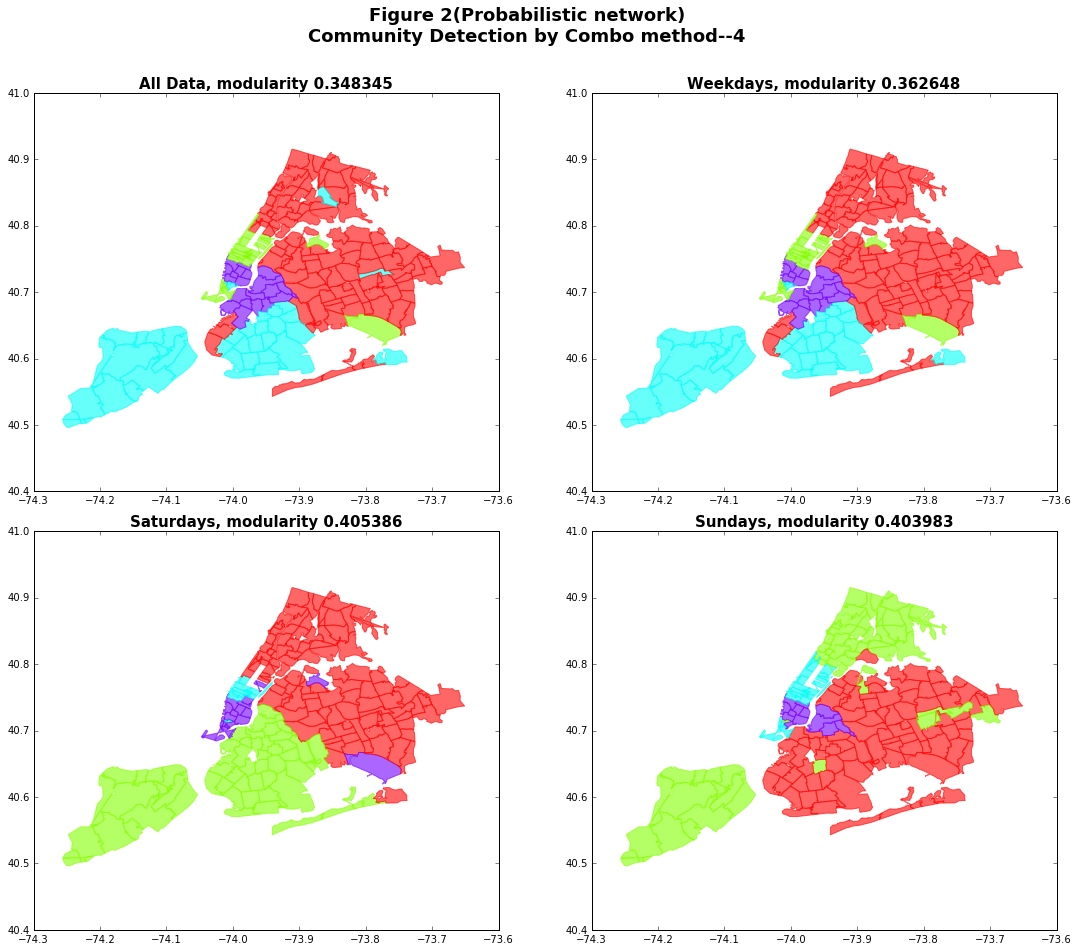

In [69]:
fig2 = plt.figure(num = 2, figsize = (20,15))
plt.suptitle('Figure 2(Probabilistic network)\nCommunity Detection by Combo method--4', fontweight="bold", size=18)
for i in range(4):
    ClusterRanking[i] = CommPartShape(fig2, Graph2[i], P_CP4[i],i)

### Step 4, some data visualization and demonstration

### A) First glance, twitter users' daily activities, with weekends highlighted

In [70]:
def DailyActivity():
    start_date = datetime.fromtimestamp(time.mktime(TimeList[0][0])).date()
    end_date = datetime.fromtimestamp(time.mktime(TimeList[0][-1])).date()
    day_count = (end_date-start_date).days
    DateList = [start_date + timedelta(n) for n in range(day_count)]
    T_ACT = {i:0 for i in DateList}
    for single_day in DateList:
        day_list = [x for x in Data[0].DateTime if datetime.fromtimestamp(time.mktime(x)).date() == single_day]
        T_ACT[single_day] = len(day_list)
    Thanksgiving = date(2015, 11, 26)
    Christmas = date(2015, 12, 25)
    NewYear = date(2016, 1, 1)
    a = Thanksgiving - start_date
    b = date(2015,12,1) - start_date
    c = Christmas - start_date
    d = NewYear - start_date
    e = date(2016,2,1) - start_date
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(111)
    ax.set_title("Daily Twitter Activities", fontweight="bold", size=18)
    bar = ax.bar(range(day_count), T_ACT.values(), color = ['g','g','g','r','r','g','g'] , align='center', width = 1.5)
    ax.legend((bar[0],bar[4]), ('Weekdays', 'Weekends'), loc = 2, prop={'size':18})
    ax.set_xticks([0,a.days, b.days, c.days, d.days, e.days])
    ax.set_xticklabels(['Nov/4/2015','Thanksgiving','Dec/1/2015','Christmas','New Year','Feb/1/2016'],
                       rotation=90, fontsize = 14)
    plt.show()

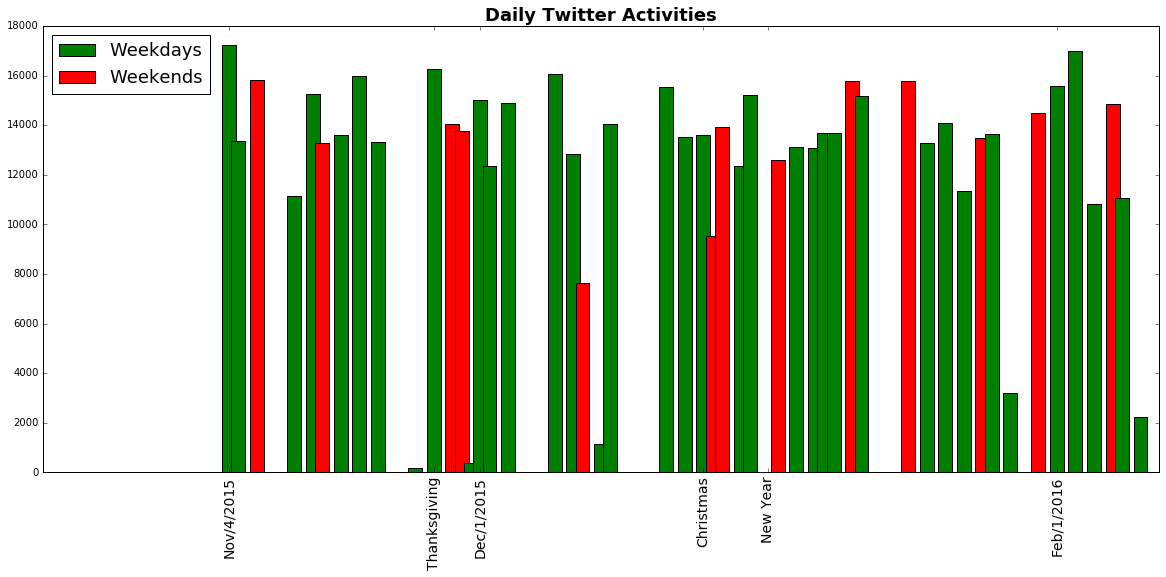

In [71]:
DailyActivity()

### B) Top places (zip codes) with highest amount of tweets, marked in map

In [72]:
def TopZipCode(fig, date_index, top = 10):
    ziplist = sort(Data[date_index].ZipCode.unique())
    percentage_ziplist = {i:0 for i in ziplist}
    T = len(Data[date_index])
    for i in ziplist:
        percentage_ziplist[i] = 100.0 * len(Data[date_index][Data[date_index].ZipCode == i])/T
    sorted_ziplist = sorted(percentage_ziplist.items(), key=operator.itemgetter(1), reverse = 1)
    new_ziplist = [x[0] for x in sorted_ziplist]
    percentage = [x[1] for x in sorted_ziplist]
    
    title = ['All days','Weekdays', 'Saturdays', 'Sundays']
    ax = fig.add_subplot(221 + date_index)
    plt.title(title[date_index], fontweight="bold", size=15)
    ax.bar(range(top), percentage[:top], color='g')
    ax.set_xticks(range(top))
    ax.set_xticklabels(new_ziplist[:top], fontsize = 13-top/4, fontweight="bold", rotation = 30)
    plt.subplots_adjust(hspace = 0.2, wspace = 0.1)
    return new_ziplist[:top]

#### You can change the number of "top" as you want to see the difference (but make sure you've loaded all the prerequisite data in previous cells)

In [73]:
top = 20

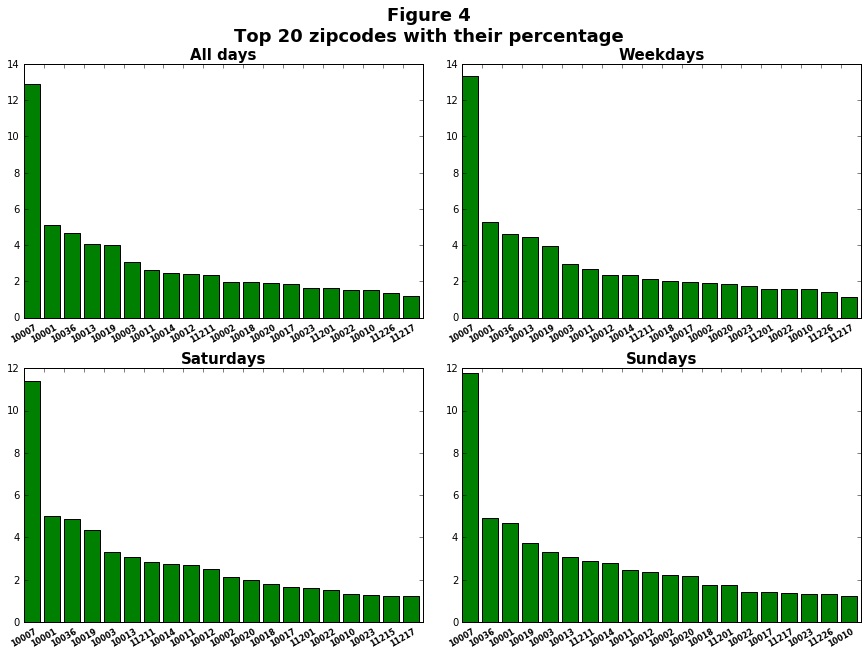

In [74]:
TopZip = range(4)
fig4 = plt.figure(num = 4, figsize = (15,10))
plt.suptitle('Figure 4\nTop %d zipcodes with their percentage'%top, fontweight="bold", size=18)
for i in range(4):
    TopZip[i] = TopZipCode(fig4, i, top)

In [75]:
def HighlightTopMap(fig, G, partition, date_index):
    '''This functin is for plotting geographical maps with 4 arguments:
    fig: for subplotting purpose mainly, usually not necessary
    G: the graph, does not have to be directed, for modularity computation
    partitin: self-explanatory, although it can be non-integers
    data_index: 0 denoting all data, and 1, 2, 3 for weekday, Saturday, Sunday
    '''
    if max([a-int(a) for a in partition.values()])==0:
        level = len(set(partition.values()))
        cmap = matplotlib.cm.hsv(np.linspace(0,1,level + 1))
        mode = 1
    else:
        cmap = matplotlib.cm.cool(np.linspace(0,1,128))
        mode = 2
        v2 = log(max(partition.values()))
        v1 = log(min(partition.values()))
    title = ['All Data','Weekdays', 'Saturdays', 'Sundays']
    
    ClusterList = [ (j, partition.values().count(j)*1.0/len(partition)) for j in set(partition.values())]
    ClusterList.sort(key = operator.itemgetter(1), reverse = 1)
    ClusterRanking = [i[0] for i in ClusterList]
    
    Color = range(level+1)
    for i in range(level+1):
        Color[i] = cmap[i][0:3]
    Color[-1][:] = 0
    Legend = ['Community %d'%i for i in arange(1,level+1)]
    Legend.append('Top %d Zip Codes'%top)
        
    ax = fig.add_subplot(221 + date_index)
    plt.title(title[date_index]+', modularity %f' % modularity(G,partition), fontweight="bold", size=15)
    for s in range(lzipsf):
        z = int(zipsf_records[s][1][-5:])
        if z in partition.keys():
            k = partition[z]
            if mode == 2:
                k = int((log(k)-v1)/(v2-v1)*127.9999)
            shape = zipsf_shape[s]
            w = [(i[0],i[1]) for i in shape.shape.points]
            poly = Polygon(w)
            if z in TopZip[date_index]:
                c = Color[-1]
                ax.add_patch(PolygonPatch(poly, fc = c, ec = c, alpha = 1, zorder = 2))
            else:
                c = Color[ClusterRanking.index(k)]
                ax.add_patch(PolygonPatch(poly, fc = c, ec = c, alpha = 0.6, zorder = 2))
    ax.axis('scaled')
    #handles, labels = ax.get_legend_handles_labels()
    #plt.legend(Legend, loc = 2, prop = {'size':9})
    #ax.legend(Color, Legend, loc = 2, prop={'size':8})
    plt.subplots_adjust(hspace = 0.1, wspace = 0)
    return ClusterRanking

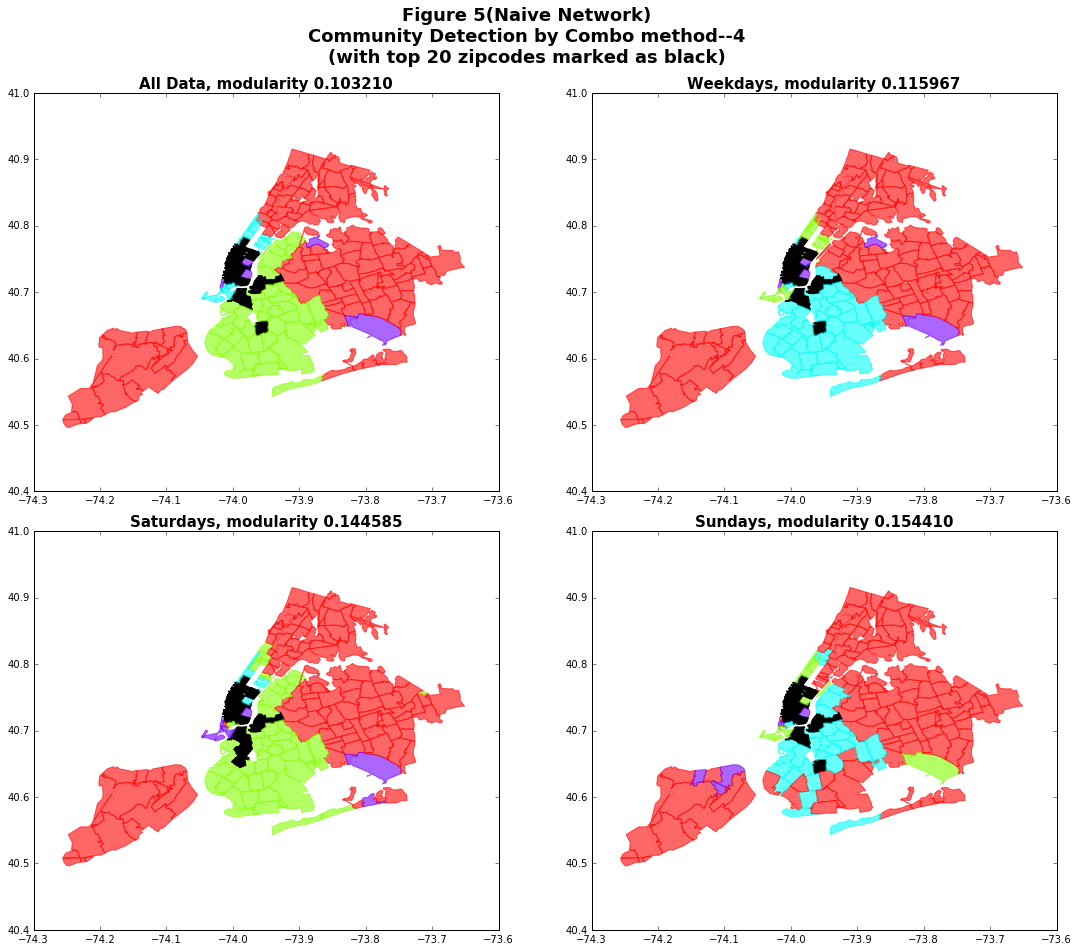

In [76]:
fig5 = plt.figure(num = 5, figsize = (20,15))
plt.suptitle('Figure 5(Naive Network)\nCommunity Detection by Combo method--4\n'+\
             '(with top %d zipcodes marked as black)' %top,fontweight="bold", size=18)
for i in range(4):
    HighlightTopMap(fig5, Graph[i], N_CP4[i],i)

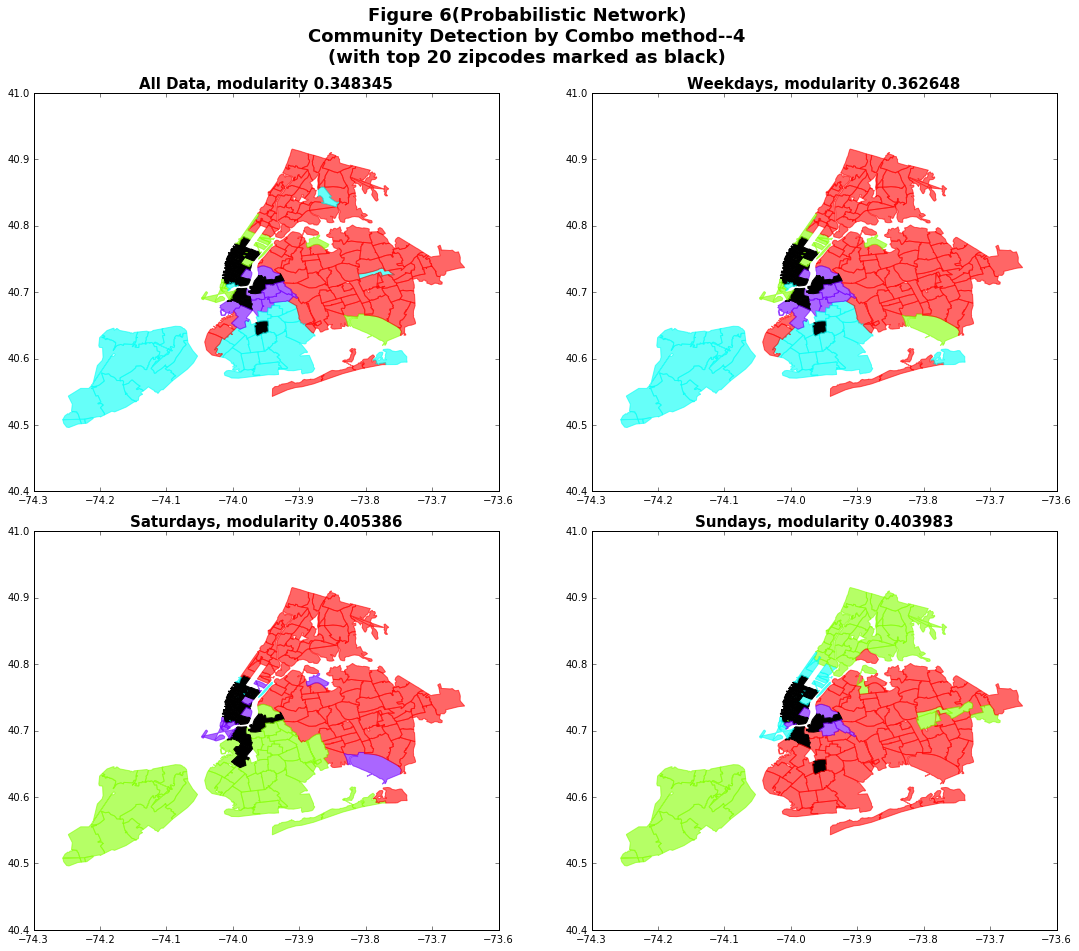

In [77]:
fig6 = plt.figure(num = 6, figsize = (20,15))
plt.suptitle('Figure 6(Probabilistic Network)\nCommunity Detection by Combo method--4\n'+\
             '(with top %d zipcodes marked as black)' %top,fontweight="bold", size=18)
for i in range(4):
    HighlightTopMap(fig6, Graph2[i], P_CP4[i],i)

#### C) Some demographic data of New York gathered in 2014

In [78]:
Demographic=pd.read_csv("/Users/CQ/Documents/Project1/Demographic_2014.csv", low_memory=False)
variable_names=list(Demographic.iloc[0,:])
#first row is variable name
Demographic=Demographic.iloc[1:,:]
Demographic.index=range(len(Demographic))
#get zipcode from the strange string
zipcode=pd.DataFrame([int(Demographic.loc[i,'Name of Area'].split(" ")[0]) for i in range(len(Demographic))])
Demographic.columns=variable_names
Demographic=pd.concat((zipcode,Demographic),axis=1)
Demographic=Demographic.rename(columns={0:'zipcode'})

* Slice and simplify the dataframe according to our zipcode database so we can focus on New York instead of the whole country

In [79]:
Demo_NY = Demographic[Demographic.zipcode.isin(Data[0].ZipCode.unique())]

## First plotting the sample base, which is the "All days" category, then we observe if there's any interesting features showing on each community based on our partition

fig4 = plt.figure(num = 4, figsize = (20,15))
plt.suptitle('Figure 4(Loop edges included)\nCommunity Detection by Combo method--4', fontweight="bold", size=18)
for i in range(4):
    CommPartShape(fig4, D_Graph2[i], CP4[i],i)

In [80]:
def CommunityDetection(date_index = 0):
    partition = P_CP4[date_index]
    level = max(partition.values()) + 1
    cmap = matplotlib.cm.hsv(np.linspace(0,1, level +1))
    fig = plt.figure(figsize = (20,15))
    ax = fig.add_subplot(111)
    LABEL = ['Community %d'%(i+1) for i in range(level)]
    LABEL.append(LABEL[0])
    plt.title('Community Detection of NYC based on Twitter activities', fontweight="bold", size=15)
    for s in range(lzipsf):
        z = int(zipsf_records[s][1][-5:])
        if z in partition.keys():
            k = partition[z]
            c = cmap[ClusterRanking[date_index].index(k)][0:3]
            shape = zipsf_shape[s]
            w = [(i[0],i[1]) for i in shape.shape.points]
            poly = Polygon(w)
            ax.add_patch(PolygonPatch(poly, fc = c, ec = 'k', alpha = 0.7, zorder = 2))
    ax.axis('scaled')
    plt.legend(LABEL[1:])
    plt.show()

In [81]:
def ShowFeature(feature_name, partition, LEGEND, date_index = 0):
    '''date_index has the similar function here: controlling the sample base
    0--All days
    1--Weekdays
    2--Saturdays
    3--Sundays
    with 0 being the default'''
    feature_len = len(feature_name)
    data = Demo_NY.loc[:,feature_name]
    data.fillna(value = 0)
    data = data.applymap(int)
    data['ZipCode'] = Demo_NY.zipcode
    zip_intersection = set(data.ZipCode) & set(partition.keys())
    data = data[data.ZipCode.isin(zip_intersection)]
    data['Part'] = [partition[i] for i in data.ZipCode]
    grouped = data.iloc[:,:-2].groupby(data.Part)
    SUM = grouped.sum()*1.0
    RATIO = SUM.divide(sum(SUM, axis = 1), axis = 0)
    level = len(set(partition.values()))
    plt.figure(figsize = (20, 9))
    x = range(level)
    #bar_step = arange(start = -(feature_len-4)*.5, stop = (feature_len)*.5, step = .5)
    LABEL = ['Community %d'%(i+1) for i in x]
    #Width = 12.0/feature_len/level
    bar_stacked = range(feature_len+1)
    Color = matplotlib.cm.hsv(np.linspace(0,1,level + 10))
    #ax1 = plt.subplot(211)
    #for i in range(feature_len):
    #    ax1.bar(x+bar_step[i]*2*Width, SUM.iloc[:,i][ClusterMatch[date_index]] ,width = Width,
    #            color = Color[i+1])#, align='center')
    #plt.legend(LEGEND)
    #plt.title('Total population of each category', fontweight="bold", size = 18)
    #ax1.set_xticks(range(level))
    #ax1.set_xticklabels(LABEL, fontsize = 14, fontweight="bold", rotation = 30)
    ax2 = plt.subplot()
    for i in range(feature_len):
        bar_stacked[i] = RATIO.iloc[:,i][ClusterRanking[date_index]]
        if i == 0:
            ax2.bar(x,bar_stacked[i], width = 0.2, label = LEGEND[i], color = Color[i+1], align = 'center')
            bottom_bar = bar_stacked[i]
        else:
            ax2.bar(x,bar_stacked[i], width = 0.2, bottom = bottom_bar, label = LEGEND[i],
                    color = Color[i+1], align = 'center')
            bottom_bar = [s+t for s,t in zip(bottom_bar,bar_stacked[i])]
    plt.legend(LEGEND)#, loc = 2)
    plt.title('Ratio of each category', fontweight="bold", size = 18)
    ax2.set_xticks(range(level))
    ax2.set_xticklabels(LABEL, fontsize = 18, fontweight="bold")
    plt.show()

# The legend is right, I intentionally match the text with color but now community 1 is at the bottom instead of top. Please allow me some time to fix it

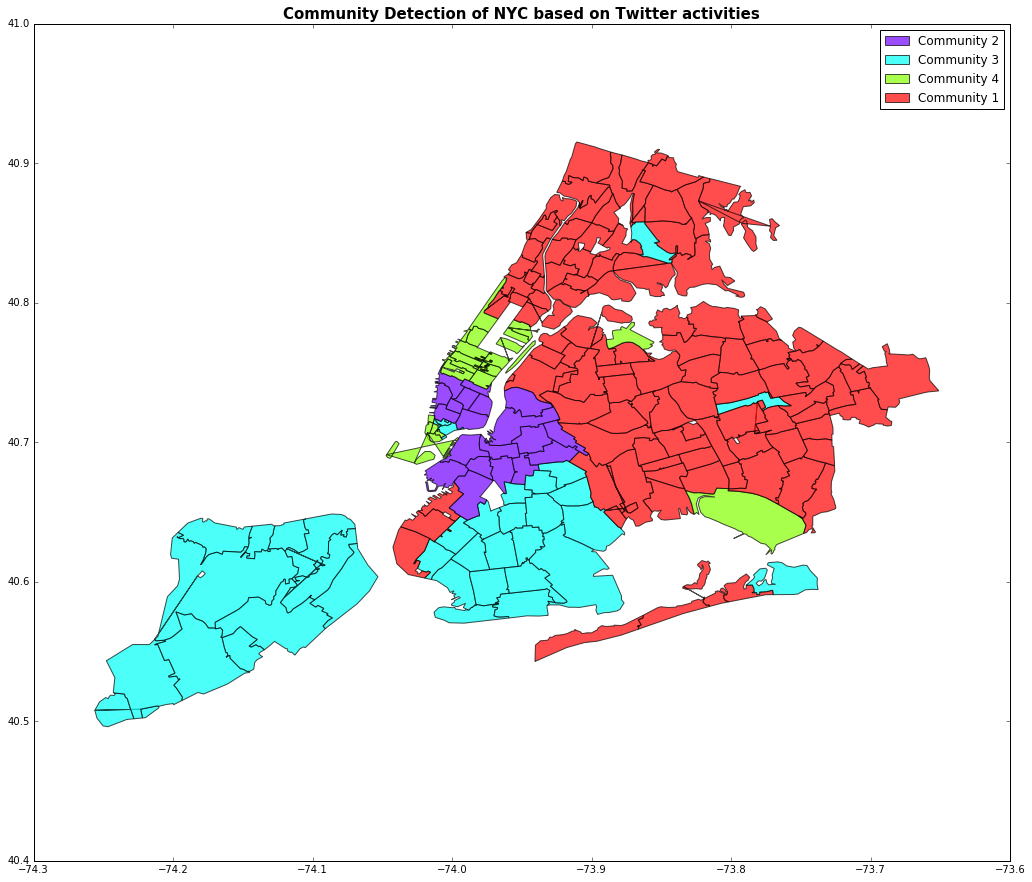

In [82]:
CommunityDetection()

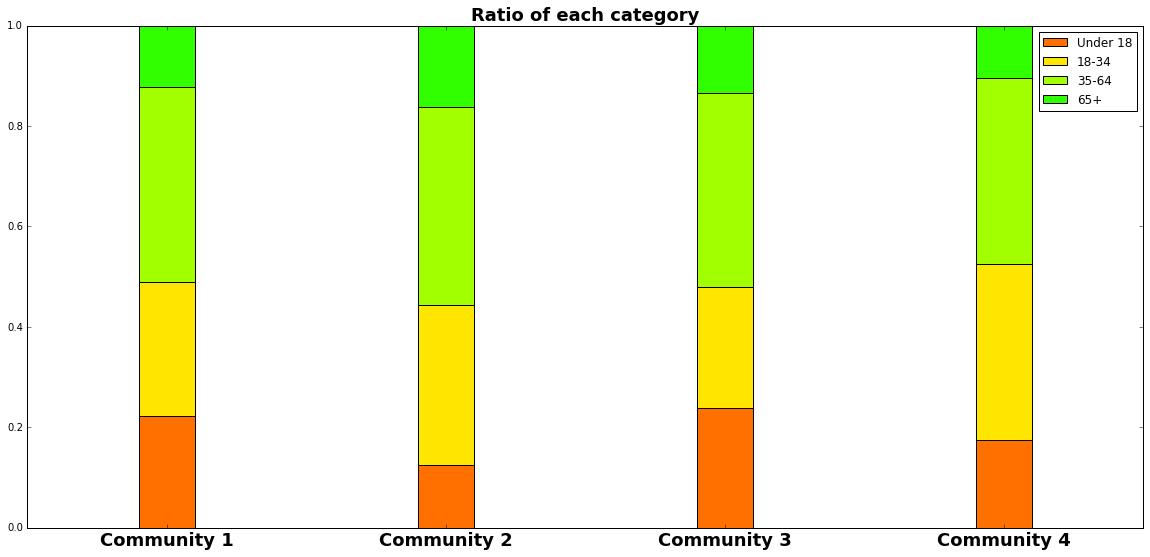

In [83]:
population = ['SE_T009_002','SE_T009_003','SE_T009_004','SE_T009_005']
legend_pop = ['Under 18', '18-34', '35-64', '65+']
#'SE_T001_001' is the Total population
ShowFeature(population,P_CP4[0],legend_pop)

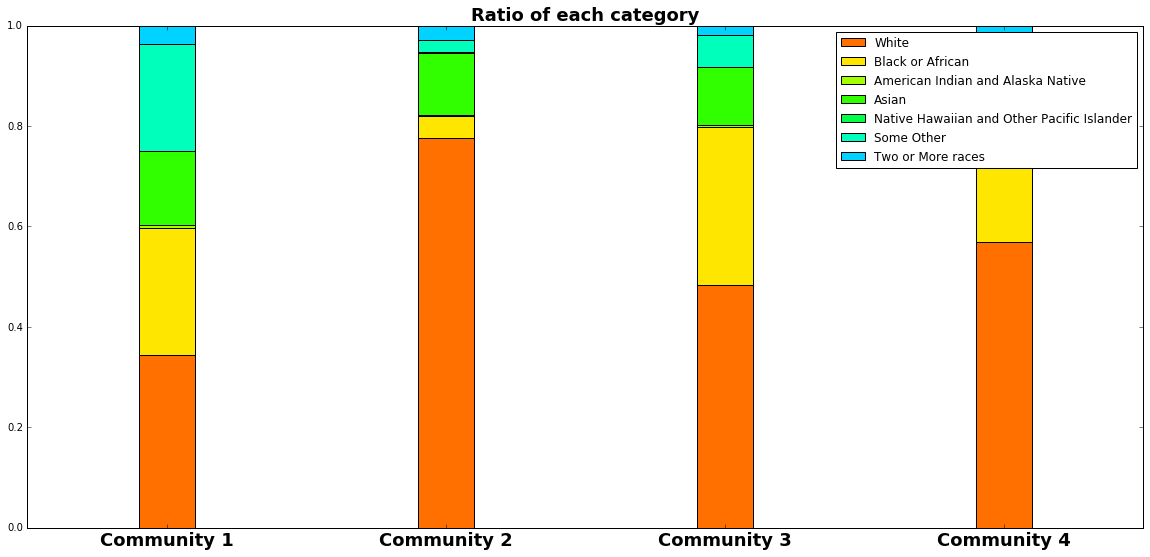

In [84]:
race = ['SE_T013_002','SE_T013_003','SE_T013_004','SE_T013_005','SE_T013_006','SE_T013_007','SE_T013_008']
legend_race = ['White', 'Black or African', 'American Indian and Alaska Native', 'Asian',
            'Native Hawaiian and Other Pacific Islander', 'Some Other', 'Two or More races']
#'SE_T013_001' is the Total population
ShowFeature(race,P_CP4[0],legend_race)

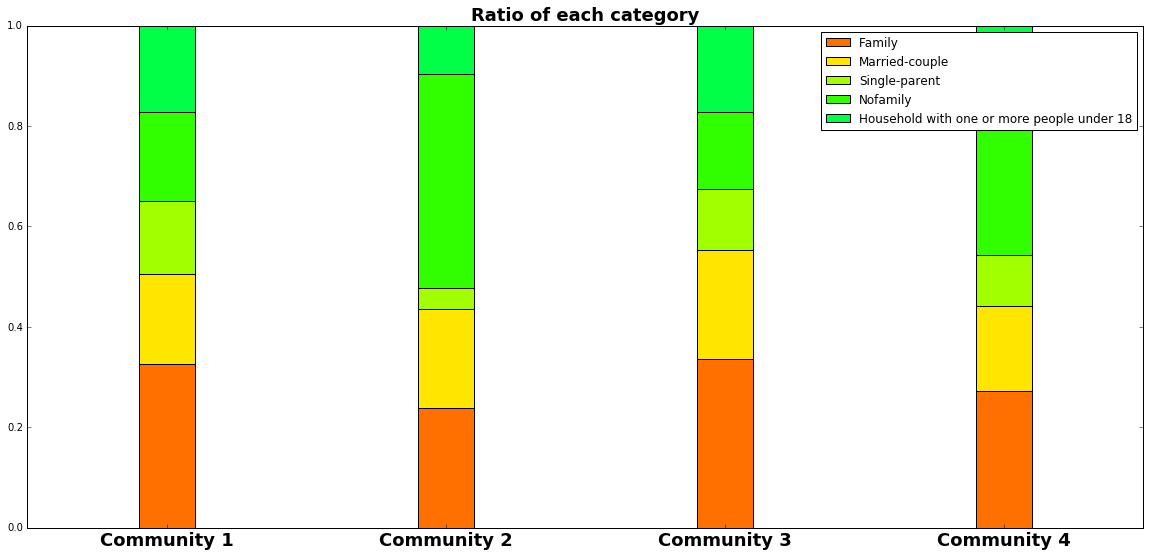

In [85]:
households = ['SE_T017_002','SE_T017_003','SE_T017_004','SE_T017_007','SE_T018_002']
legend_households = ['Family', 'Married-couple', 'Single-parent', 'Nofamily',
                     'Household with one or more people under 18']
#'SE_T017_001' is the Total Households
ShowFeature(households,P_CP4[0],legend_households)

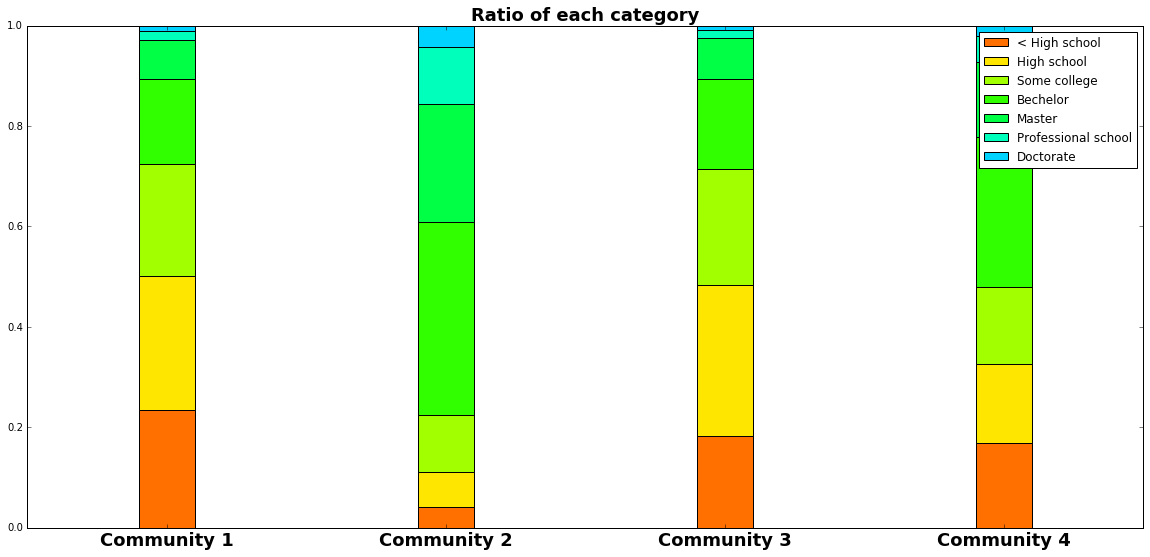

In [86]:
education = ['SE_T025_002','SE_T025_003','SE_T025_004','SE_T025_005','SE_T025_006','SE_T025_007','SE_T025_008']
legend_edu = ['< High school','High school', 'Some college', 'Bechelor', 'Master', 'Professional school', 'Doctorate']
# 'SE_T025_001'is the Total Population over 25
ShowFeature(education,P_CP4[0],legend_edu)

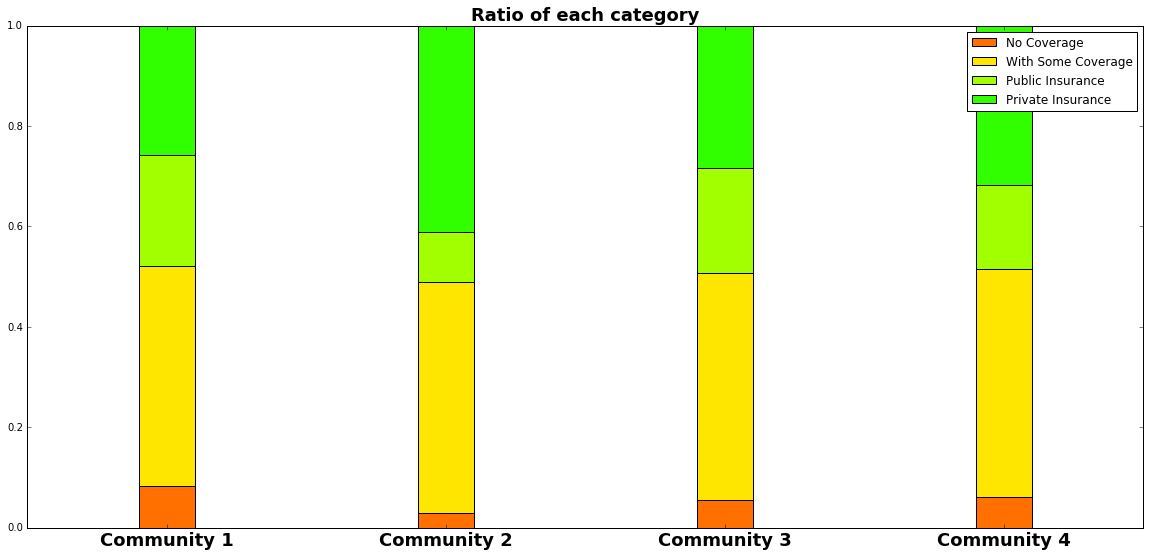

In [87]:
insurance=['SE_T145_002','SE_T145_003','SE_T145_004','SE_T145_005']
#'SE_T145_001' is the Total number, and 
legend_insur = ['No Coverage','With Some Coverage', 'Public Insurance', 'Private Insurance']
ShowFeature(insurance,P_CP4[0],legend_insur)

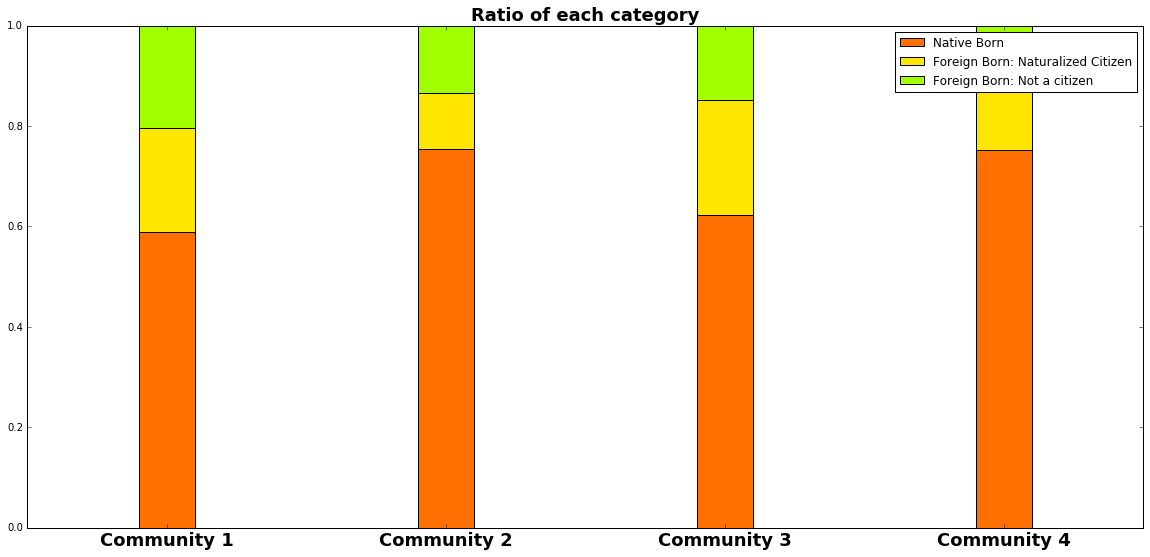

In [88]:
born_place = ['SE_T133_002','SE_T133_004','SE_T133_005']
legend_born = ['Native Born','Foreign Born: Naturalized Citizen', 'Foreign Born: Not a citizen']
#'SE_T133_001' Total Population; 'SE_T133_003',Foreign Born
ShowFeature(born_place, P_CP4[0],legend_born)

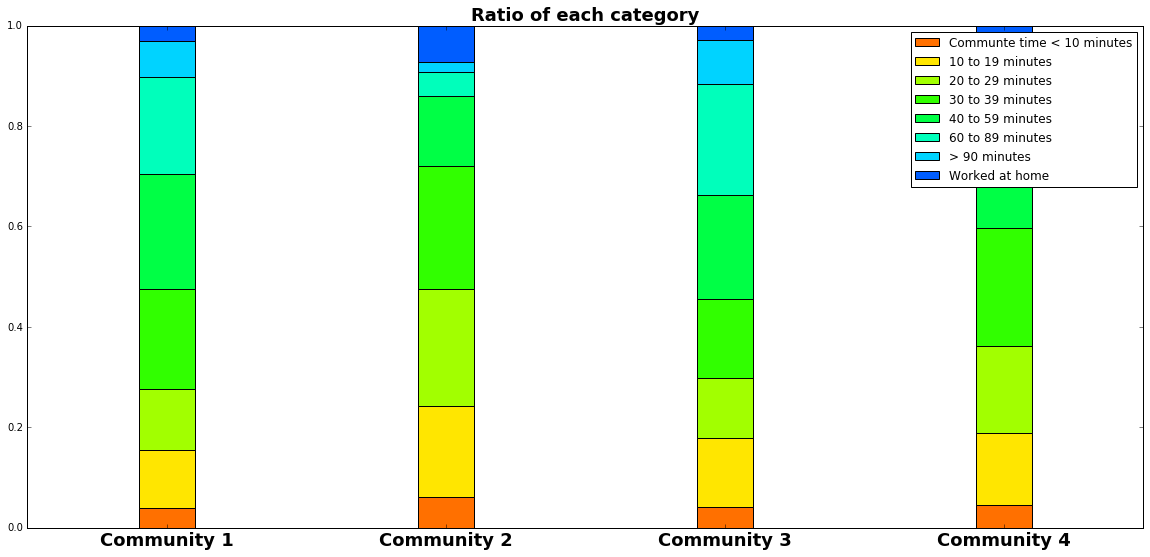

In [89]:
commute_time = ['SE_T129_003','SE_T129_004','SE_T129_005',
                     'SE_T129_006','SE_T129_007','SE_T129_008','SE_T129_009','SE_T129_010']
# 'SE_T129_001', Workers 16 Years and over; 'SE_T129_002', did not work at home
legend_commute_time = ['Communte time < 10 minutes','10 to 19 minutes','20 to 29 minutes','30 to 39 minutes',
                       '40 to 59 minutes','60 to 89 minutes','> 90 minutes', 'Worked at home']
ShowFeature(commute_time,P_CP4[0],legend_commute_time)

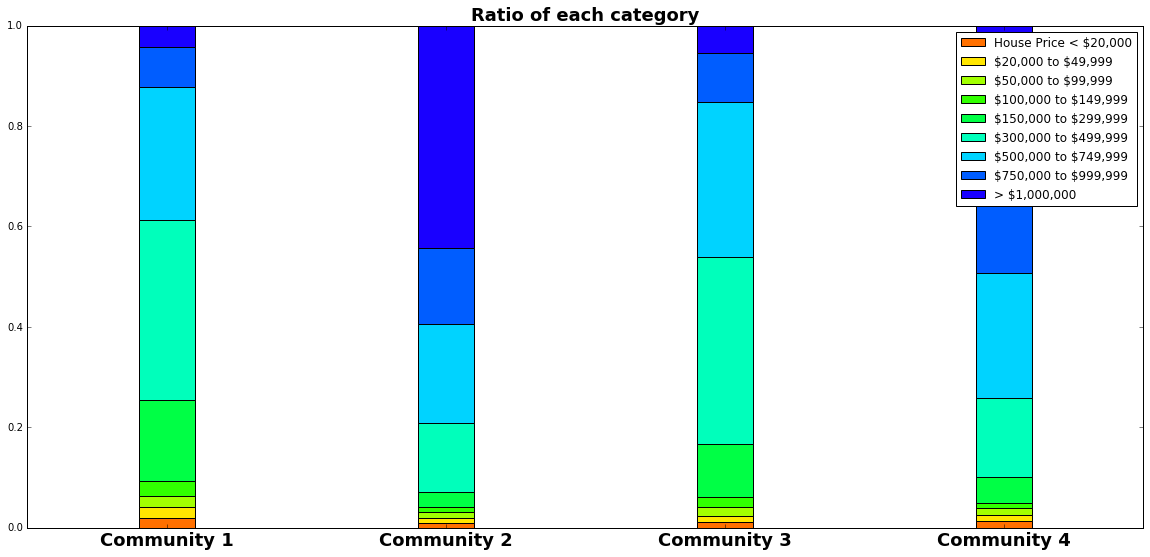

In [90]:
House_price =['SE_T100_002','SE_T100_003','SE_T100_004','SE_T100_005',
                  'SE_T100_006','SE_T100_007','SE_T100_008','SE_T100_009','SE_T100_010']
legend_house_price = ['House Price < $20,000','\$20,000 to $49,999','\$50,000 to $99,999','\$100,000 to $149,999',
                      '\$150,000 to $299,999','\$300,000 to $499,999','\$500,000 to $749,999','\$750,000 to $999,999',
                      '> $1,000,000']
#'SE_T100_001', Owner-occupied housing units
ShowFeature(House_price,P_CP4[0],legend_house_price)

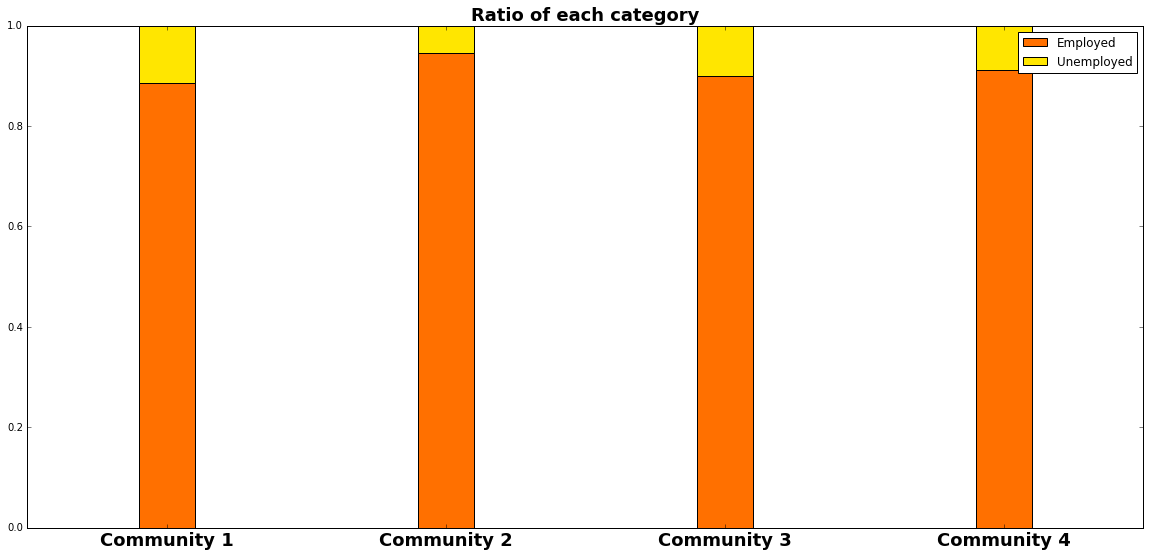

In [91]:
employment = ['SE_T037_002','SE_T037_003']
legend_emp = ['Employed', 'Unemployed']
# 'SE_T037_001' is the total Civilian Population In Labor Force 16 Years And Over
ShowFeature(employment,P_CP4[0],legend_emp)

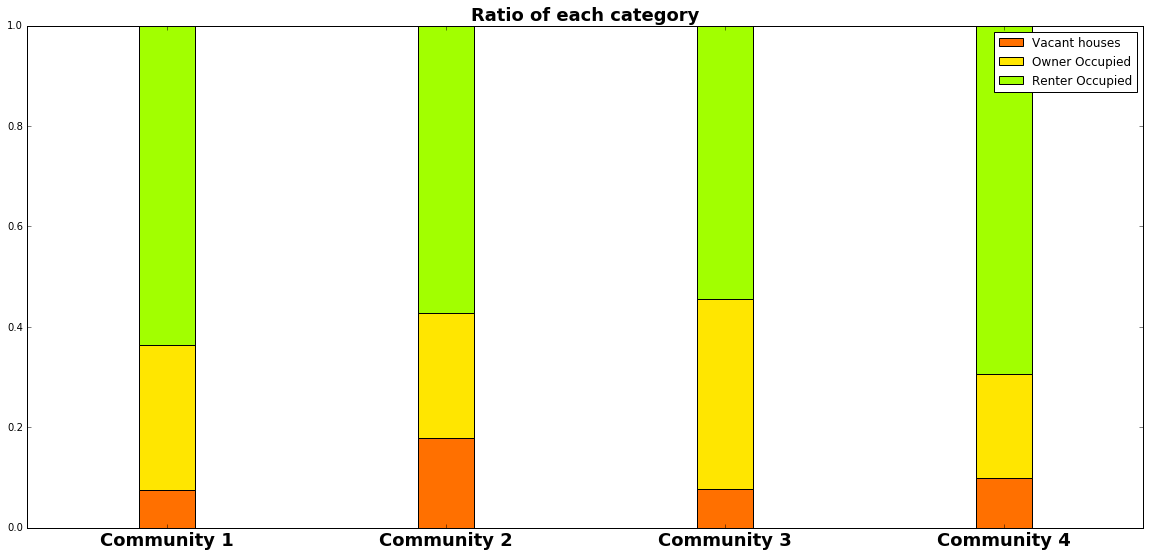

In [92]:
type_house = ['SE_T095_003','SE_T094_002','SE_T094_003']
legend_housetype = ['Vacant houses','Owner Occupied','Renter Occupied']
#'SE_T094_001','Occupied houses'
ShowFeature(type_house, P_CP4[0],legend_housetype)

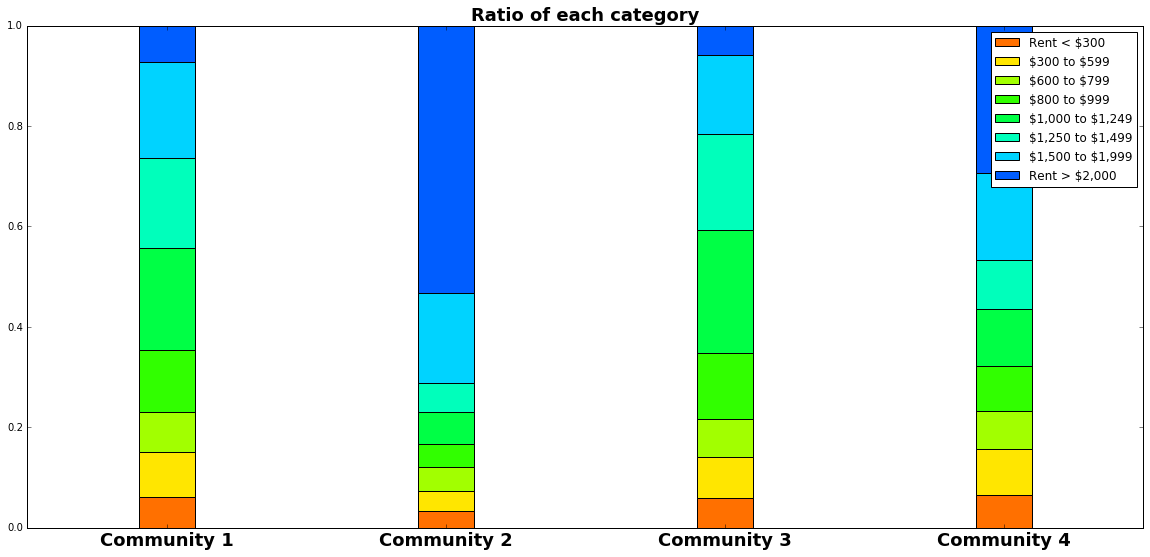

In [93]:
Rent_price=['SE_T102_002','SE_T102_003','SE_T102_004','SE_T102_005',
            'SE_T102_006','SE_T102_007','SE_T102_008','SE_T102_009']
#'SE_T102_001', Renter-occupied housing units with cash rent
legen_rent_price = ['Rent < $300','\$300 to $599','\$600 to $799','\$800 to $999','\$1,000 to $1,249',
                    '\$1,250 to $1,499','\$1,500 to $1,999','Rent > $2,000']
ShowFeature(Rent_price, P_CP4[0],legen_rent_price)

# So far the tests show some reasonable observations:
## In our network, community 2 and 4 are mainly located in Manhattan, clearly the richest community among all 4, and it can be seen by the categories such as house price, rent price, education level etc.

In [94]:
weight = [Graph2[0][i][j]['weight'] for (i,j) in Graph2[0].edges()]

In [95]:
sum(weight)

0.93292515606777859